# Point vortex flow solver: so fast! 
See bottom cell for history, license, explanations

Copyright 2019 Lisa Schielicke, contact: lisa.schielicke@met.fu-berlin.de

Streamfunction added by Brian Mapes, bmapes@miami.edu

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  # Use ODEINT to solve the differential equations 

In [74]:
# Strengths of vortices. Tracer particles have zero circulation:
G=[-1.0*10**6,-0.1*10**6,0.5*10**6,1.3*10**6,-0.8*10**6,4*10**6,2*10**6,0,0,0,0,0]

sizeofpointinplot=[10,1,5,13,8,25,16,2,2,2,2,2] # Please give a representative size, the point vortex 
                                                # should have in the plot. E.g., make the points
                                                # bigger for larger absolute circulations
dotcolor = []
for k in range(0,len(G)):
    if G[k]>0.:
      dotcolor.append('r') # plot cyclonic vortices red
    if G[k]<0.:
      dotcolor.append('b') # plot anticyclonic vortices blue
    if G[k]==0.:
      dotcolor.append('k') # plot streamers black

# Be careful: Do not put two vortices (or tracers) at the same location! This will give errors.
x=[0.,10000,15000,20000,25000,30000,35000,5000,13000,17000,24000,33000] #in m
y=[0.,0,0,0,0,0,0,0,0,0,0,0]                         #in m

# ODE solver parameters, change if necessary
abserr = 1.0e-10    # absolute error measures of the ode solver
relerr = 1.0e-10    # absolute error measures of the ode solver
stoptime = 3600*1*1 # integration time in seconds
numpoints = 300     # defines the time steps of the integration via: 
                    #    t=[stoptime*float(i)/(numpoints-1) for i in range(numpoints)]


plottitle = 'N=7 point vortex system' #give a nice title for your plots


In [98]:
def strfunc(xx,yy,w,G,minforlog):
##########################################################################      
#  Uses log(radius) Greens function to construct streamfunction 
#                                                                               
#  Arguments:                                                                   
#        xx,yy :  v2D coordinate arrays ector of the x,y-coordinates of each point vortex:               
#                  w = [x1,y1,x2,y2]                                            
#        G :  vector of the N circulations                                      
##########################################################################      

  # Make a grid for streamfunction contours
  psi = xx*0 # coordinate array sized array of zeros
  x = w[0::2] #    x : vector of the x-coordinates of the N point vortices
  y = w[1::2] #    y : vector of the y-coordinates of the N point vortices
  
  # Loop over vortices, summing up a grid of inverse log distances 
  for j in range(0,len(G)):
    # calculate the realtive distance between point vortex j and all other points
    disty=y[j]-yy 
    distx=x[j]-xx
    invlogdist= 1.0/np.log(disty**2+distx**2 +minforlog) # add 1 just to keep log safe
#    print('shape of yy, disty, psi, invlogdist,G ', yy.shape, disty.shape, psi.shape, invlogdist.shape, G[j])

    psi -= G[j]*invlogdist

  return psi


In [4]:
def pveq(w, t, G, difft):
##########################################################################
#  Defines the differential equations for a point vortex system of N points
#
#  Arguments:
#        w :  vector of the x,y-coordinates of each point vortex:
#                  w = [x1,y1,x2,y2]
#        t :  time
#        G :  vector of the N circulations
##########################################################################
  x = w[0::2] #    x : vector of the x-coordinates of the N point vortices
  y = w[1::2] #    y : vector of the y-coordinates of the N point vortices
#
# Create f = (x1',u1',y1',v1',x2',u2',y2',v2',...,xN',uN',yN',vN'):
  f=[]
  for j in range(0,len(G)):
    # calculate the realtive distance between point vortex j and all other point vortices
    disty=y[j]-y 
    distx=x[j]-x
    reldistsq=disty**2+distx**2
    # calculate the new coordinates (point vortex equations for [x- , y-coordinate])
    f.extend([-1/(2*np.pi)*np.sum(G[reldistsq!=0]*disty[reldistsq!=0]/(reldistsq[reldistsq!=0])),1/(2*np.pi)*np.sum(G[reldistsq!=0]*distx[reldistsq!=0]/(reldistsq[reldistsq!=0]))])

  return f



In [5]:
#calculate the coordinates of the common center of circulation
Circcenterx=np.sum(np.asarray(G[:])*np.asarray(x[:]))/np.sum(np.asarray(G[:]))
Circcentery=np.sum(np.asarray(G[:])*np.asarray(y[:]))/np.sum(np.asarray(G[:]))

# Create the time samples for the output of the ODE solver.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
w0 = []
for i in range(0,len(G)):
  w0.append(x[i])
  w0.append(y[i])

difft=np.diff(t)[0]

# Call the ODE solver
wsol = odeint(pveq, w0, t, args=(np.asarray(G),difft),atol=abserr, rtol=relerr)


In [87]:
wsol[0]

array([    0.,     0., 10000.,     0., 15000.,     0., 20000.,     0.,
       25000.,     0., 30000.,     0., 35000.,     0.,  5000.,     0.,
       13000.,     0., 17000.,     0., 24000.,     0., 33000.,     0.])

In [91]:
# Unpack results into xlocs, ylocs
xlocs = wsol[:, 0:2*len(G):2]
ylocs = wsol[:, 1:2*len(G):2]

In [92]:
xlocs.shape

(300, 12)

In [114]:
# For streamfunction psi, need a grid
xaxis = np.linspace(0,70000,101)
yaxis = np.linspace(-35000,35000,101)
xx, yy = np.meshgrid(xaxis, yaxis)

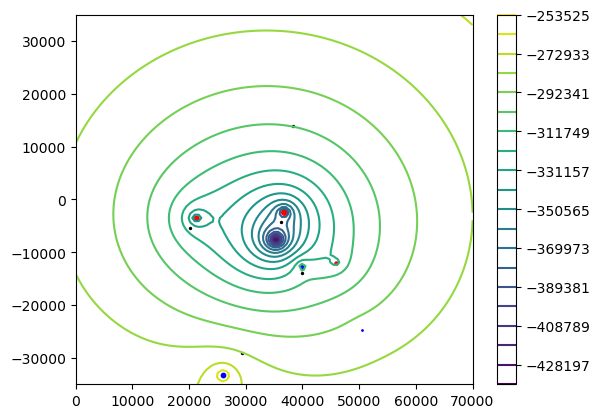

In [124]:
# Calculate one streamfunction, and set contour interval 
tt = 100
sf = strfunc(xx,yy,wsol[tt],G,minforlog=1e5)
minsf = sf.min()
maxsf = sf.max()

# Make a plot to check at this time tt
plt.contour(xaxis,yaxis,sf,levels=np.linspace(minsf,maxsf,20))
plt.colorbar()
for k in range(len(G)): 
    plt.scatter(xlocs[tt,k],ylocs[tt,k],sizeofpointinplot[k], color=dotcolor[k])

# Make an animation

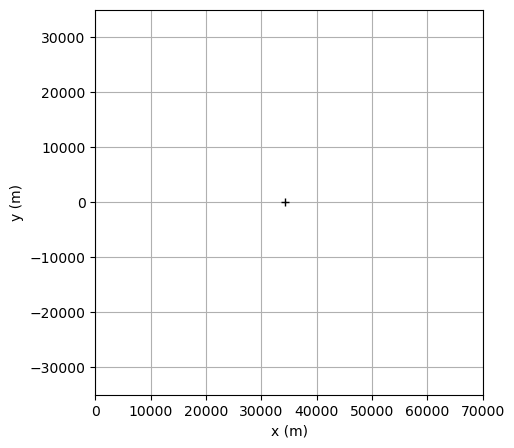

In [152]:
# create a figure and axes
fig = plt.figure(figsize=(5,5))
ax  = plt.subplot()   
ax.clear()
ax.grid()
ax.set_xlim([xaxis.min(),xaxis.max()])
ax.set_ylim([yaxis.min(),yaxis.max()])
ax.plot(Circcenterx,Circcentery,'k+',markersize=6)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
  
def animate(tyme):
  #print('tyme=',tyme)
  ax.clear()
  ax.grid()
  ax.plot(Circcenterx,Circcentery,'k+',markersize=6)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  sf = strfunc(xx,yy,wsol[tyme],G,minforlog=1e5)
  ax.contour(xaxis,yaxis,sf,levels=np.linspace(minsf,maxsf,20),linewidths=0.3)
  for k in range(len(G)): 
    ax.scatter(xlocs[tyme,k],ylocs[tyme,k],sizeofpointinplot[k], color=dotcolor[k])



In [153]:
anim = animation.FuncAnimation(fig, animate,48,interval=100, blit=False)
from IPython.display import HTML
HTML(anim.to_jshtml())

In [ ]:
# pvmotion.py
# calculates the motion of N point vortices on a plane and produces a "movie" showing the point vortex motion
# (in the movie, red(blue) dots represent point vortices of positive(negative) circulations, black dots are
# tracer particels (their circulation is zero). Black + symbol represents the common circulation center.
# Feel free to change the code!
#
#---------------------------------------------------------------------------------------------------------------------
# Copyright 2019 Lisa Schielicke, contact: lisa.schielicke@met.fu-berlin.de
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
#
#---------------------------------------------------------------------------------------------------------------------
#   A short overview over the license can be found here: https://choosealicense.com/licenses/apache-2.0/
#   (last access: 10 Oct 2017)
#---------------------------------------------------------------------------------------------------------------------
#  If you are interested in the topic of point vortex motion, please read through (and cite if appropriate) our 
#  publications:
#
#  Annette Mueller, Peter Nevir, Lisa Schielicke, Mirjam Hirt, Joscha Pueltz & Isabell Sonntag (2015) Applications
#  of point vortex equilibria: blocking events and the stability of the polar vortex, Tellus A: Dynamic Meteorology 
#  and Oceanography, 67:1, DOI: 10.3402/tellusa.v67.29184 
#  https://doi.org/10.3402/tellusa.v67.29184
#
#  Mirjam Hirt, Lisa Schielicke, Annette Mueller & Peter Nevir (2018) Statistics and dynamics of blockings with a 
#  point vortex model, Tellus A: Dynamic Meteorology and Oceanography, 70:1, 1-20, DOI: 10.1080/16000870.2018.1458565
#  https://doi.org/10.1080/16000870.2018.1458565
#
#---------------------------------------------------------------------------------------------------------------------
#  created: 23 Feb 2019 (Lisa Schielicke)
#						
#---------------------------------------------------------------------------------------------------------------------
#